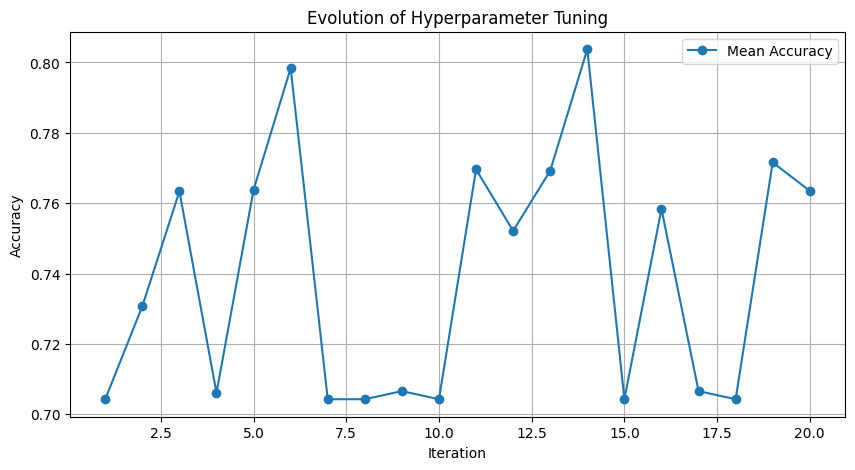

---------------------------------------------


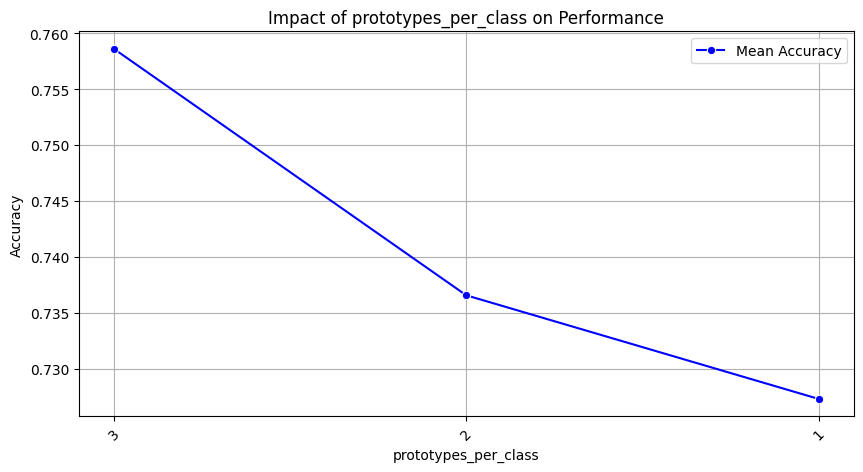

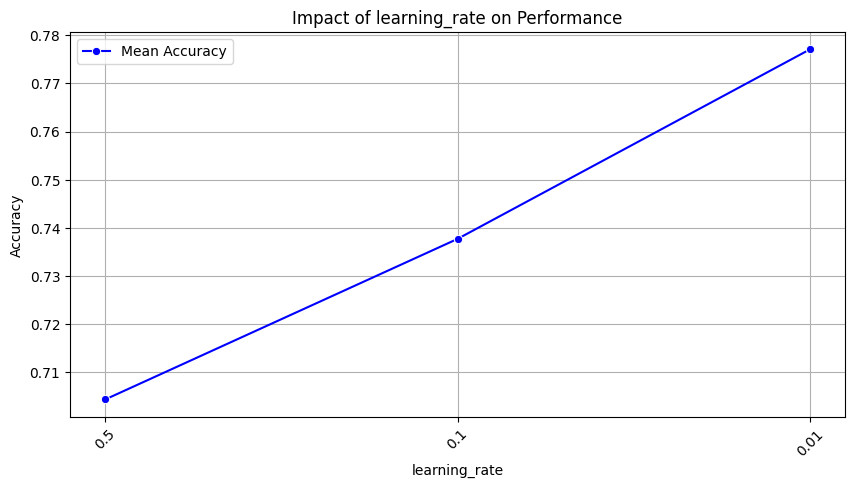

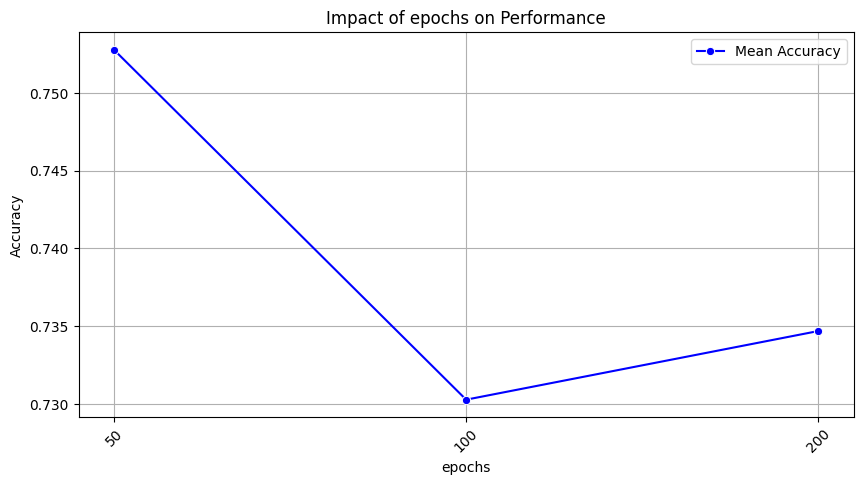


Melhores hiperparâmetros encontrados:
{'prototypes_per_class': 3, 'learning_rate': 0.01, 'epochs': 50}

Desempenho no conjunto de teste:
Acurácia: 0.7762
Precisão: 0.8589
Recall: 0.8155
F1-score: 0.8366
AUC-ROC: 0.7493


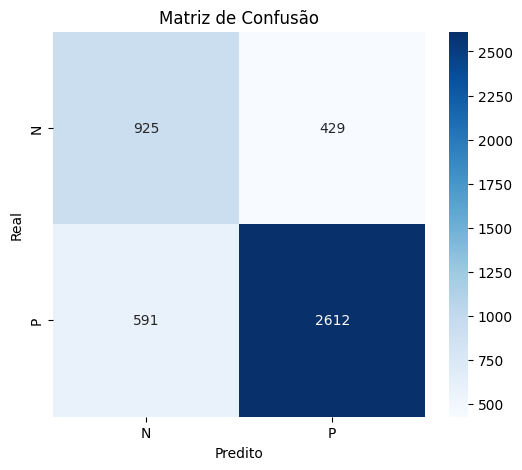


Relatório de Classificação:
              precision    recall  f1-score   support

           N       0.61      0.68      0.64      1354
           P       0.86      0.82      0.84      3203

    accuracy                           0.78      4557
   macro avg       0.73      0.75      0.74      4557
weighted avg       0.79      0.78      0.78      4557



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.base import BaseEstimator, ClassifierMixin

# Carregar dados
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Separar features e target
X_train = train_df.drop(columns=['binaryClass'])
y_train = train_df['binaryClass']
X_test = test_df.drop(columns=['binaryClass'])
y_test = test_df['binaryClass']

# Converter rótulos para valores numéricos
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Implementação do LVQ
class LVQ(BaseEstimator, ClassifierMixin):
    def __init__(self, prototypes_per_class=1, learning_rate=0.1, epochs=100):
        self.prototypes_per_class = prototypes_per_class
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.prototypes = None
        self.labels = None

    def fit(self, X, y):
        unique_classes = np.unique(y)
        num_classes = len(unique_classes)
        self.prototypes = np.zeros((num_classes * self.prototypes_per_class, X.shape[1]))
        self.labels = np.zeros(num_classes * self.prototypes_per_class)

        for i, cls in enumerate(unique_classes):
            idx = np.where(y == cls)[0]
            selected = np.random.choice(idx, self.prototypes_per_class, replace=False)
            self.prototypes[i * self.prototypes_per_class: (i + 1) * self.prototypes_per_class] = X[selected]
            self.labels[i * self.prototypes_per_class: (i + 1) * self.prototypes_per_class] = cls

        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
                sample = X[i]
                label = y[i]
                distances = np.linalg.norm(self.prototypes - sample, axis=1)
                winner_idx = np.argmin(distances)

                if self.labels[winner_idx] == label:
                    self.prototypes[winner_idx] += self.learning_rate * (sample - self.prototypes[winner_idx])
                else:
                    self.prototypes[winner_idx] -= self.learning_rate * (sample - self.prototypes[winner_idx])
        return self

    def predict(self, X):
        y_pred = []
        for sample in X:
            distances = np.linalg.norm(self.prototypes - sample, axis=1)
            winner_idx = np.argmin(distances)
            y_pred.append(self.labels[winner_idx])
        return np.array(y_pred)

# Configurar RandomizedSearchCV
param_dist = {
    'prototypes_per_class': [1, 2, 3],
    'learning_rate': [0.01, 0.1, 0.5],
    'epochs': [50, 100, 200]
}

lvq_model = LVQ()
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(lvq_model, param_distributions=param_dist, n_iter=20, cv=kfold, scoring='accuracy', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

def plot_search_results(results):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(results['mean_test_score']) + 1), results['mean_test_score'], marker='o', linestyle='-', label='Mean Accuracy', alpha=1.0)
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.title("Evolution of Hyperparameter Tuning")
    plt.legend()
    plt.grid()
    plt.show()
    print('---------------------------------------------')

results_df = pd.DataFrame(random_search.cv_results_)
plot_search_results(results_df)

# Plotar evolução dos hiperparâmetros
def plot_hyperparameter_evolution(results, param_name):
    param_values = [str(param) for param in results['param_' + param_name]]
    mean_scores = results['mean_test_score']

    df = pd.DataFrame({
        'param_value': param_values,
        'mean_score': mean_scores
    })

    plt.figure(figsize=(10, 5))
    sns.lineplot(x='param_value', y='mean_score', data=df, marker='o', label='Mean Accuracy', color='b', errorbar=None)
    plt.xlabel(param_name)
    plt.ylabel("Accuracy")
    plt.title(f"Impact of {param_name} on Performance")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.show()

for param in ['prototypes_per_class', 'learning_rate', 'epochs']:
    if 'param_' + param in results_df.columns:
        plot_hyperparameter_evolution(results_df, param)

# Melhor modelo
best_lvq = random_search.best_estimator_
y_pred = best_lvq.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("\nMelhores hiperparâmetros encontrados:")
print(random_search.best_params_)
print("\nDesempenho no conjunto de teste:")
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

<ipython-input-6-da3627112876>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=metrics, palette='viridis')


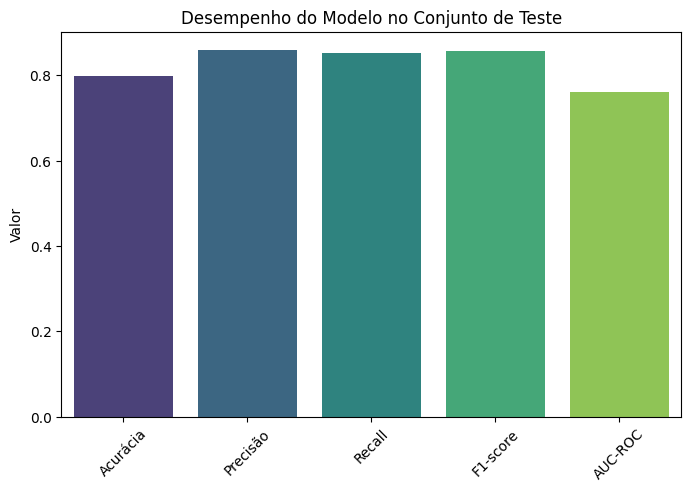

F1-score no Treino: 0.8589
F1-score no Teste: 0.8558
O modelo apresenta um equilíbrio entre treino e teste.


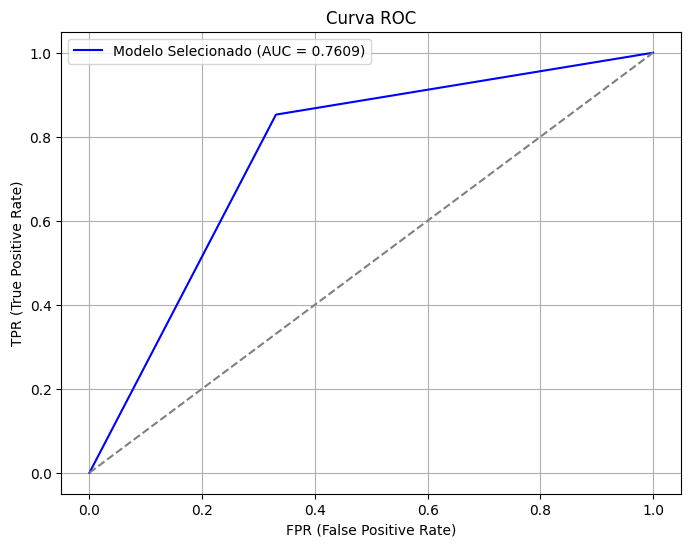

In [ ]:
from sklearn.metrics import roc_curve

# Comparação de Desempenho
metrics = [accuracy, precision, recall, f1, roc_auc]
labels = ["Acurácia", "Precisão", "Recall", "F1-score", "AUC-ROC"]
plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=metrics, palette='viridis')
plt.title("Desempenho do Modelo no Conjunto de Teste")
plt.ylabel("Valor")
plt.xticks(rotation=45)
plt.show()

# Overfitting vs. Underfitting
train_pred = best_lvq.predict(X_train)
train_f1 = f1_score(y_train, train_pred)
print(f"F1-score no Treino: {train_f1:.4f}")
print(f"F1-score no Teste: {f1:.4f}")

if train_f1 - f1 > 0.1:
    print("O modelo pode estar sofrendo de overfitting.")
elif f1 - train_f1 > 0.1:
    print("O modelo pode estar sofrendo de underfitting.")
else:
    print("O modelo apresenta um equilíbrio entre treino e teste.")

# Curva ROC
if hasattr(best_lvq, 'predict_proba'):
    y_prob = best_lvq.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
elif hasattr(best_lvq, 'predict'):
    y_prob = best_lvq.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
else:
    raise AttributeError("O modelo não possui métodos para prever probabilidades ou decisões.")

# Plot da Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Modelo Selecionado (AUC = {roc_auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.title("Curva ROC")
plt.legend()
plt.grid()
plt.show()


Melhor prototypes_per_class: 3 com acurácia 0.7641


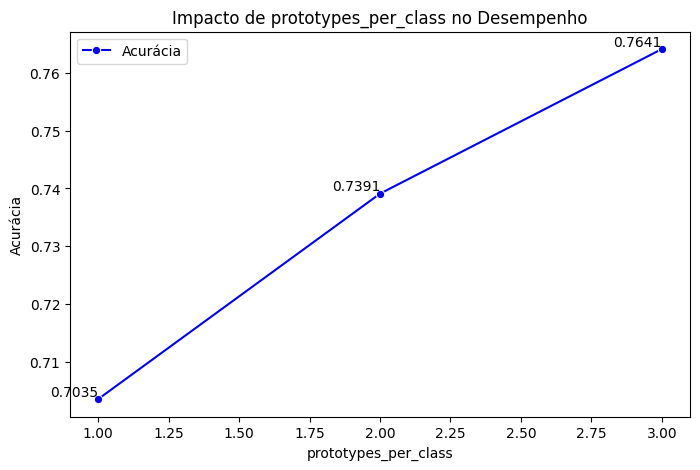

Melhor learning_rate: 0.01 com acurácia 0.7582


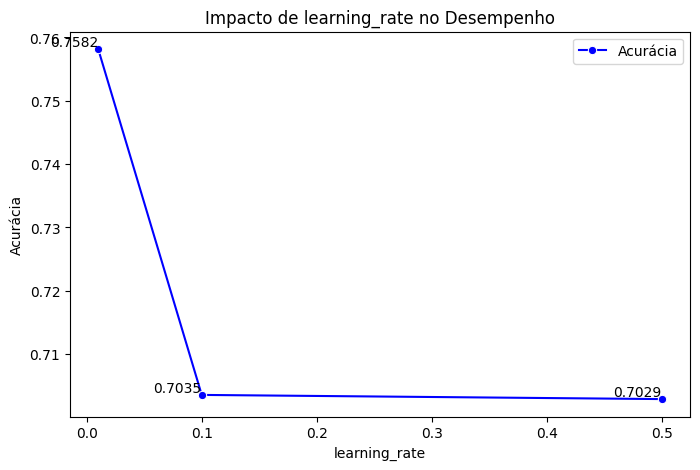

Melhor epochs: 50 com acurácia 0.7035


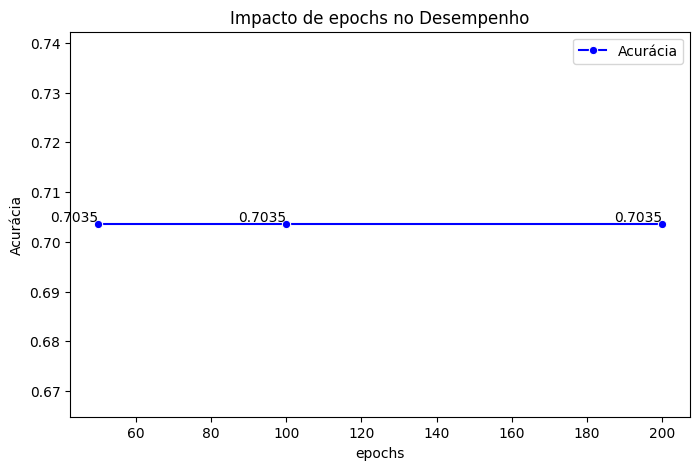


Desempenho no conjunto de teste:
Acurácia: 0.7979
Precisão: 0.8590
Recall: 0.8523
F1-score: 0.8557
AUC-ROC: 0.7607


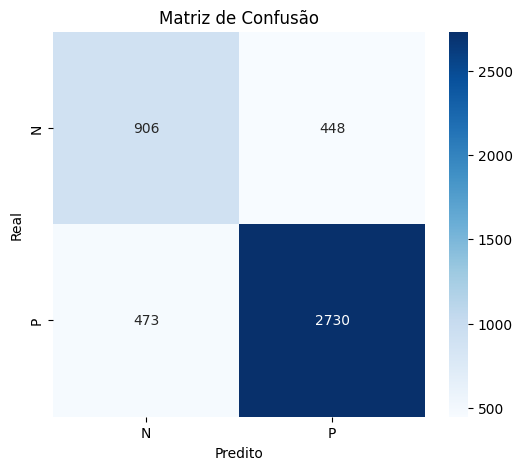


Relatório de Classificação:
              precision    recall  f1-score   support

           N       0.66      0.67      0.66      1354
           P       0.86      0.85      0.86      3203

    accuracy                           0.80      4557
   macro avg       0.76      0.76      0.76      4557
weighted avg       0.80      0.80      0.80      4557



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Carregar dados
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Separar features e target
X_train = train_df.drop(columns=['binaryClass'])
y_train = train_df['binaryClass']
X_test = test_df.drop(columns=['binaryClass'])
y_test = test_df['binaryClass']

# Converter rótulos para valores numéricos
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Implementação do LVQ
class LVQ:
    def __init__(self, prototypes_per_class=1, learning_rate=0.1, epochs=100):
        self.prototypes_per_class = prototypes_per_class
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.prototypes = None
        self.labels = None

    def fit(self, X, y):
        unique_classes = np.unique(y)
        num_classes = len(unique_classes)
        self.prototypes = np.zeros((num_classes * self.prototypes_per_class, X.shape[1]))
        self.labels = np.zeros(num_classes * self.prototypes_per_class)

        for i, cls in enumerate(unique_classes):
            idx = np.where(y == cls)[0]
            selected = np.random.choice(idx, self.prototypes_per_class, replace=False)
            self.prototypes[i * self.prototypes_per_class: (i + 1) * self.prototypes_per_class] = X[selected]
            self.labels[i * self.prototypes_per_class: (i + 1) * self.prototypes_per_class] = cls

        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
                sample = X[i]
                label = y[i]
                distances = np.linalg.norm(self.prototypes - sample, axis=1)
                winner_idx = np.argmin(distances)

                if self.labels[winner_idx] == label:
                    self.prototypes[winner_idx] += self.learning_rate * (sample - self.prototypes[winner_idx])
                else:
                    self.prototypes[winner_idx] -= self.learning_rate * (sample - self.prototypes[winner_idx])

    def predict(self, X):
        y_pred = []
        for sample in X:
            distances = np.linalg.norm(self.prototypes - sample, axis=1)
            winner_idx = np.argmin(distances)
            y_pred.append(self.labels[winner_idx])
        return np.array(y_pred)

# Avaliar hiperparâmetros individualmente
def evaluate_hyperparameter(values, param_name):
    accuracies = []
    for value in values:
        params = {'prototypes_per_class': 1, 'learning_rate': 0.1, 'epochs': 100}
        params[param_name] = value
        lvq = LVQ(**params)
        lvq.fit(X_train, y_train)
        y_pred = lvq.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))

    best_value = values[np.argmax(accuracies)]
    print(f"Melhor {param_name}: {best_value} com acurácia {max(accuracies):.4f}")
    plot_results(param_name, values, accuracies)
    return best_value

# Função para plotar resultados
def plot_results(param_name, values, accuracies):
    plt.figure(figsize=(8, 5))
    sns.lineplot(x=values, y=accuracies, marker='o', color='b', label='Acurácia')
    for x, y in zip(values, accuracies):
        plt.text(x, y, f'{y:.4f}', ha='right', va='bottom', fontsize=10, color='black')
    plt.xlabel(param_name)
    plt.ylabel('Acurácia')
    plt.title(f'Impacto de {param_name} no Desempenho')
    plt.legend()
    plt.show()

# Definir valores a testar
prototypes_per_class_values = [1, 2, 3]
learning_rate_values = [0.01, 0.1, 0.5]
epochs_values = [50, 100, 200]

# Encontrar melhores hiperparâmetros individualmente
best_prototypes_per_class = evaluate_hyperparameter(prototypes_per_class_values, 'prototypes_per_class')
best_learning_rate = evaluate_hyperparameter(learning_rate_values, 'learning_rate')
best_epochs = evaluate_hyperparameter(epochs_values, 'epochs')

# Treinar o modelo com os melhores hiperparâmetros
lvq = LVQ(prototypes_per_class=best_prototypes_per_class, learning_rate=best_learning_rate, epochs=best_epochs)
lvq.fit(X_train, y_train)
y_pred = lvq.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("\nDesempenho no conjunto de teste:")
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=le.classes_))
